# Load Data

In [1]:
import pandas as pd

data_path = './datasets/labels.csv'
img_dir = './datasets/images/'

data = pd.read_csv(data_path, header=None, names=['filename', 'score'])

# Print sum of each score
print(data.groupby('score').size())


score
0     29
1     56
2     55
3     47
4    113
dtype: int64


## Plotting the Distribution Data

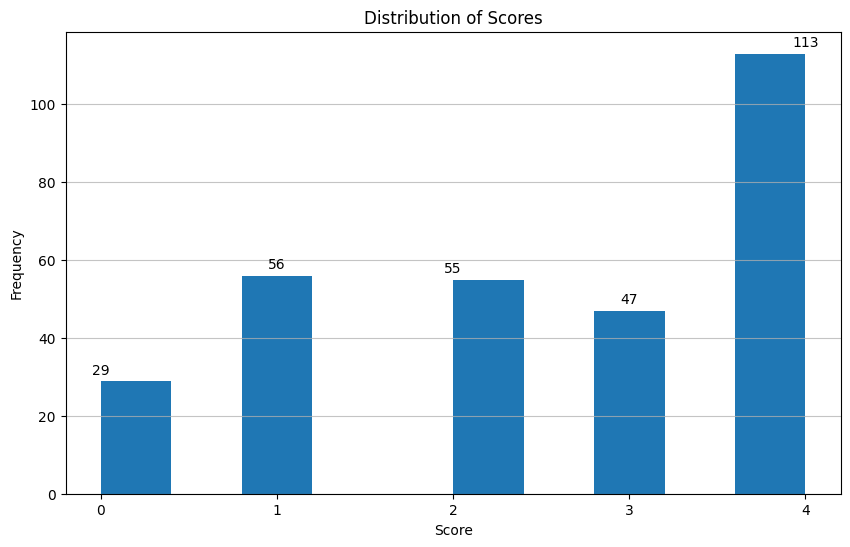

In [2]:
import matplotlib.pyplot as plt

# Plot the distribution of scores
plt.figure(figsize=(10, 6))
plt.hist(data['score'], align='mid')
plt.xticks(range(0, 5))
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')
plt.grid(axis='y', alpha=0.75)
# show each number frequency above the bar
for i in range(0, 5):
    count = data[data['score'] == i].shape[0]
    plt.text(i, count + 1, str(count), ha='center', va='bottom')
# plt.savefig('score_distribution.png')
plt.show()

## Show the first 5 image of the datasets

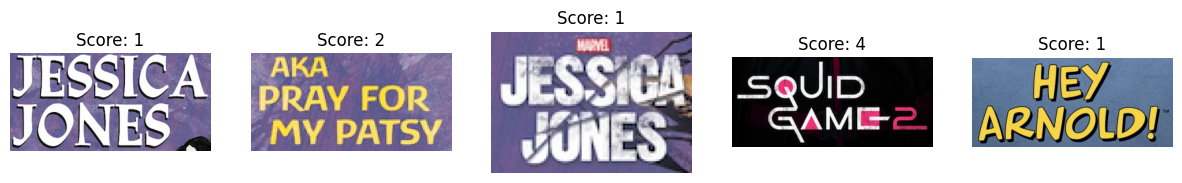

In [3]:
# Show the first 5 images from datasets
import os 
import cv2
import matplotlib.pyplot as plt
import numpy as np

def show_images(data, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        filename = data.iloc[i]['filename']
        score = data.iloc[i]['score']
        img = cv2.imread(os.path.join(img_dir, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f'Score: {score}')
        plt.axis('off')
    plt.show()

show_images(data, n=5)

# Data Processing

## Convert Image into Gray Scale and Apply Canny Edge Detection

In [4]:
from PIL import Image

def preprocess_image(path, size=(256, 128)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 100, 200)
    resized = cv2.resize(edges, size)
    return resized / 255.0  # normalize

In [5]:
def show_image(img, title=''):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

(128, 256)
(128, 256)
(128, 256)
(128, 256)
(128, 256)


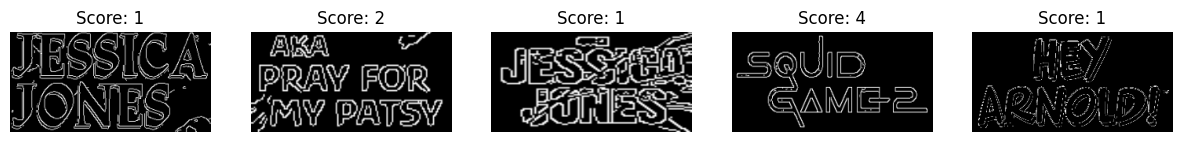

In [6]:
# plot the data applied to the first 5 images
def show_preprocessed_images(data, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        filename = data.iloc[i]['filename']
        score = data.iloc[i]['score']
        img = preprocess_image(os.path.join(img_dir, filename))
        print(img.shape)
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Score: {score}')
        plt.axis('off')
    plt.show()
show_preprocessed_images(data, n=5)

## Split Data

In [7]:
from sklearn.model_selection import train_test_split

# Preprocess images and labels
images = []
labels = []

for _, row in data.iterrows():
    img_path = os.path.join(img_dir, row['filename'])
    img = preprocess_image(img_path)  # shape: (128, 256)
    images.append(img)
    labels.append(row['score'])

images = np.array(images)[..., np.newaxis]  # shape: (N, 128, 256, 1)
labels = np.array(labels)

# First split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.15, random_state=42)

# Then split train and val from temp
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)  
# 0.1765 ≈ 15% of 85% to make it 70/15/15


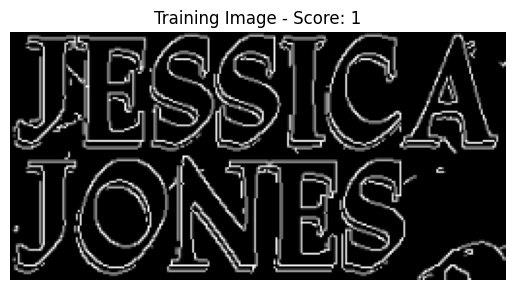

In [8]:
show_image(images[0], title=f'Training Image - Score: {labels[0]}')

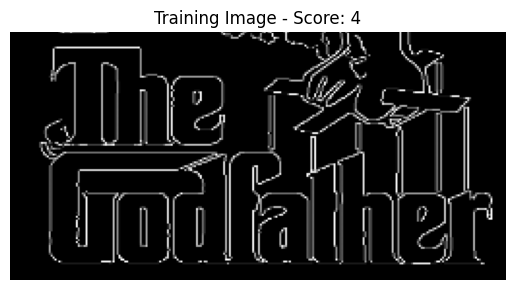

In [9]:
show_image(X_train[0], title=f'Training Image - Score: {y_train[0]}')

# Build Model

## Tensorboard Setup

In [10]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)

2025-05-08 15:48:38.637695: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 15:48:38.647158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746694118.657599   15828 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746694118.660670   15828 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-08 15:48:38.670973: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Checkpoint

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    "./models/best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)


## CNN Model

In [12]:

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight

def build_model(input_shape=(128, 256, 1), num_classes=5):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [13]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

# Build model
model = build_model(input_shape=(128, 256, 1), num_classes=5)

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[checkpoint_cb,tensorboard_cb ]
)

/home/yaomoel/Coding/comvis-final/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1746694120.130647   15828 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.2257 - loss: 2.1744
Epoch 1: val_accuracy improved from -inf to 0.17391, saving model to ./models/best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 506ms/step - accuracy: 0.2304 - loss: 2.1460 - val_accuracy: 0.1739 - val_loss: 1.5981
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.2277 - loss: 1.6638
Epoch 2: val_accuracy did not improve from 0.17391
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 379ms/step - accuracy: 0.2249 - loss: 1.6580 - val_accuracy: 0.1739 - val_loss: 1.6074
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2255 - loss: 1.5618
Epoch 3: val_accuracy did not improve from 0.17391
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step - accuracy: 0.2230 - loss: 1.5670 - val_accuracy: 0.1739 - val_loss: 1.6199
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.2289 - loss: 1.5366
Epoch 4: val_accuracy improved from 0.17391 to 0.21739, saving model to ./models/best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - accuracy: 0.2284 - loss: 1.5402 - val_accuracy: 0.2174 - val_loss: 1.5899
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.5321 - loss: 1.4709
Epoch 5: val_accuracy did not improve from 0.21739
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 405ms/step - accuracy: 0.5367 - loss: 1.4699 - val_accuracy: 0.1957 - val_loss: 1.6695
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.4771 - loss: 1.3178
Epoch 6: val_accuracy improved from 0.21739 to 0.26087, saving model to ./models/best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 421ms/step - accuracy: 0.4898 - loss: 1.3143 - val_accuracy: 0.2609 - val_loss: 1.9735
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.6806 - loss: 1.0414
Epoch 7: val_accuracy improved from 0.26087 to 0.39130, saving model to ./models/best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 405ms/step - accuracy: 0.6883 - loss: 1.0283 - val_accuracy: 0.3913 - val_loss: 2.0543
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9078 - loss: 0.4810
Epoch 8: val_accuracy did not improve from 0.39130
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step - accuracy: 0.9043 - loss: 0.4748 - val_accuracy: 0.2826 - val_loss: 3.3564
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9251 - loss: 0.2081
Epoch 9: val_accuracy did not improve from 0.39130
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step - accuracy: 0.9273 - loss: 0.2044 - val_accuracy: 0.2174 - val_loss: 3.3128
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9749 - loss: 0.0741
Epoch 10: val_accuracy did not improve from 0.39130
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - accuracy: 0.9756 - loss: 0.0728 - val_accuracy: 0.2391 - val_loss: 3.4043


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 125, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 53760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,881,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,924,177 (79.82 MB)

 Trainable params: 6,974,725 (26.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,949,452 (53.21 MB)

# Evaluation

## Plot Accuracy/Loss Graph

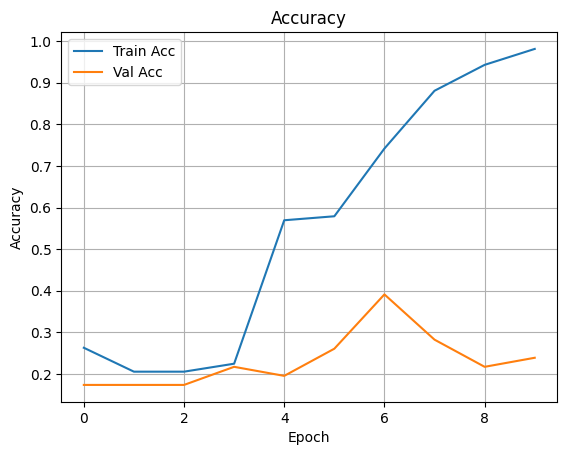

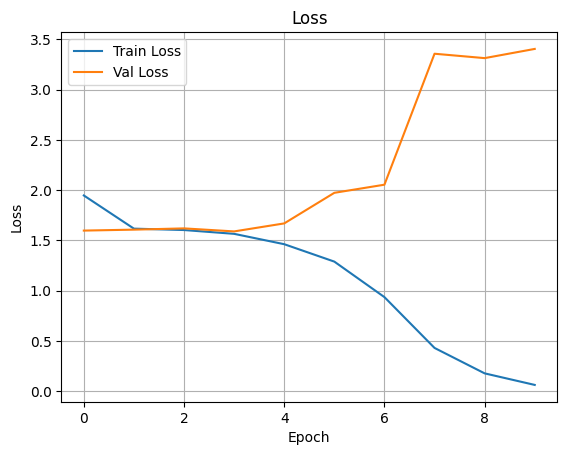

In [15]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3812 - loss: 2.9520
Test Accuracy: 0.4000 | Test Loss: 2.8687


# Predict

In [19]:
from tensorflow.keras.models import load_model

# Load saved model
model = load_model("./models/best_model.h5")

# Predict on a single image
def predict_image(path):
    img = preprocess_image(path)  # returns (128, 256)
    img = img[np.newaxis, ..., np.newaxis]  # shape: (1, 128, 256, 1)
    pred = model.predict(img)
    class_id = np.argmax(pred)
    confidence = np.max(pred)
    return class_id, confidence

# Example usage
filename = "./test4.jpeg"
label, conf = predict_image(filename)
print(f"Predicted Score: {label} (Confidence: {conf:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted Score: 2 (Confidence: 0.60)


In [23]:
image_test_dir = './datasets/images'

image_list =   os.listdir(image_test_dir)
sum_each_class_predicted = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0
}
print(image_list)
for image in image_list:
    image_path = os.path.join(image_test_dir, image)
    label, conf = predict_image(image_path)
    sum_each_class_predicted[label] += 1
    print(f'The predicted score for {image} is: {label} (Confidence: {conf:.2f})')

print("Sum of each class predicted:")
for class_label, count in sum_each_class_predicted.items():
    print(f'Class {class_label}: {count}')

['71.png', '254.png', '86.png', '293.png', '96.png', '111.png', '282.png', '202.png', '59.png', '176.png', '97.png', '2.png', '280.png', '210.png', '228.png', '240.png', '13.png', '215.png', '268.png', '144.png', '296.png', '87.png', '19.png', '50.png', '134.png', '89.png', '249.png', '115.png', '138.png', '182.png', '126.png', '20.png', '9.png', '186.png', '23.png', '295.png', '232.png', '183.png', '136.png', '248.png', '165.png', '74.png', '150.png', '179.png', '218.png', '51.png', '61.png', '273.png', '62.png', '211.png', '45.png', '252.png', '31.png', '226.png', '28.png', '14.png', '229.png', '107.png', '157.png', '43.png', '103.png', '161.png', '244.png', '29.png', '209.png', '151.png', '30.png', '44.png', '80.png', '281.png', '32.png', '190.png', '68.png', '95.png', '63.png', '121.png', '128.png', '55.png', '123.png', '46.png', '269.png', '52.png', '227.png', '47.png', '169.png', '149.png', '185.png', '79.png', '158.png', '164.png', '145.png', '38.png', '168.png', '109.png', '155